In [3]:
!pip install tensorflow
!pip install plotly
!pip install yfinance
!pip install keras

ERROR: Could not find a version that satisfies the requirement tensorflow.keras (from versions: none)
ERROR: No matching distribution found for tensorflow.keras


In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px

import yfinance as yf

In [3]:
df_reliance= yf.Ticker("RELIANCE.NS").history(period='2y').reset_index()
df_axis= yf.Ticker("AXISBANK.NS").history(period='2y').reset_index()
df_kotak= yf.Ticker("KOTAKBANK.NS").history(period='2y').reset_index()
df_icici= yf.Ticker("ICICIBANK.NS").history(period='2y').reset_index()
df_hdfc= yf.Ticker("HDFC.NS").history(period='2y').reset_index()

(497, 8)


0     2021-11-03 00:00:00+05:30
1     2021-11-04 00:00:00+05:30
2     2021-11-08 00:00:00+05:30
3     2021-11-09 00:00:00+05:30
4     2021-11-10 00:00:00+05:30
                 ...           
492   2023-10-30 00:00:00+05:30
493   2023-10-31 00:00:00+05:30
494   2023-11-01 00:00:00+05:30
495   2023-11-02 00:00:00+05:30
496   2023-11-03 00:00:00+05:30
Name: Date, Length: 497, dtype: datetime64[ns, Asia/Kolkata]

In [ ]:
Scale=StandardScaler()

In [67]:
def data_prep(df, lookback, future, Scale):
    date_train=pd.to_datetime(df['Date'])
    df_train=df[['Open','High','Low','Close','Volume','Dividends','Stock Splits']]
    df_train=df_train.astype(float)

    df_train_scaled=Scale.fit_transform(df_train)

    X, y =[],[]
    for i in range(lookback, len(df_train_scaled)-future+1):
        X.append(df_train_scaled[i-lookback:i, 0:df_train.shape[1]])
        y.append(df_train_scaled[i+future-1:i+future, 0])

    return np.array(X), np.array(y), df_train, date_train


In [68]:
def visualize_pred(X,y,df_train, model):
    pass
#     print(df_train)
#     print(X)
#     print(y)
#     fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.05)
#
# # Add multiple line charts to the subplots
#     for i, col in enumerate(df.columns[1:]):
#         fig.add_trace(
#             go.Scatter(x=df['Date'], y=df[col], mode='lines', name=col),
#             row=i+1, col=1
#         )



In [71]:
def Lstm_model(X,y):
    model=Sequential()

    model.add(LSTM(20,return_sequences=True,input_shape=(X.shape[1], X.shape[2])))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    #model.add(LSTM(15,return_sequences=True))
    #model.add(Dropout(0.2))
    #model.add(BatchNormalization())
    model.add(LSTM(15))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))

    adam = optimizers.Adam(0.001)
    model.compile(loss='mean_squared_error',optimizer=adam)

    es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
    model.fit(X, y,validation_split=0.2,epochs=1000,batch_size=64,verbose=1, callbacks=[es])
    return model

In [72]:
def predict_open(model,date_train,Lstm_x,df_train, future, Scale):
    forecasting_dates=pd.date_range(list(date_train)[-1], periods=future, freq='1d').tolist()
    predicted=model.predict(Lstm_x[-future:])
    predicted1=np.repeat(predicted, df_train.shape[1], axis=-1)
    predicted_descaled=Scale.inverse_transform(predicted1)[:,0]
    # visualize_pred(predicted_descaled, forecasting_dates)
    return predicted_descaled,forecasting_dates



In [73]:
def output_prep(forecasting_dates,predicted_descaled):
    dates=[]
    for i in forecasting_dates:
        dates.append(i.date())
    df_final=pd.DataFrame(columns=['Date','Open'])
    df_final['Date']=pd.to_datetime(dates)
    df_final['Open']=predicted_descaled
    return df_final


In [74]:
def results(df, lookback, future, Scale, x):
    Lstm_x, Lstm_y, df_train, date_train = data_prep(df, lookback, future, Scale)
    model=Lstm_model(Lstm_x,Lstm_y)
    visualize_pred(Lstm_x,Lstm_y,df_train, model)
    loss=pd.DataFrame(model.history.history)
    loss.plot()
    future=7
    predicted_descaled,forecasting_dates=predict_open(model,date_train,Lstm_x,df_train,future, Scale)
    result=output_prep(forecasting_dates,predicted_descaled)
    print(result.head())
    plt.show()
    fig = px.area(result, x="Date", y="Open", title=x)
    fig.update_yaxes(range=[result.Open.min()-10, result.Open.max()+10])
    fig.show()
    return result, model

In [4]:
pred_val, model = results(df_icici, 30, 1, Scale, 'ICICI')

SyntaxError: expected '(' (2797705390.py, line 1)

Epoch 1/1000
6/6 [==============================] - 4s 196ms/step - loss: 1.0194 - val_loss: 1.0168
Epoch 2/1000
6/6 [==============================] - 0s 18ms/step - loss: 0.6776 - val_loss: 0.9371
Epoch 3/1000
6/6 [==============================] - 0s 17ms/step - loss: 0.5003 - val_loss: 0.8652
Epoch 4/1000
6/6 [==============================] - 0s 17ms/step - loss: 0.4759 - val_loss: 0.8149
Epoch 5/1000
6/6 [==============================] - 0s 18ms/step - loss: 0.4013 - val_loss: 0.7853
Epoch 6/1000
6/6 [==============================] - 0s 17ms/step - loss: 0.4004 - val_loss: 0.7722
Epoch 7/1000
6/6 [==============================] - 0s 17ms/step - loss: 0.3498 - val_loss: 0.7610
Epoch 8/1000
6/6 [==============================] - 0s 17ms/step - loss: 0.3616 - val_loss: 0.7478
Epoch 9/1000
6/6 [==============================] - 0s 16ms/step - loss: 0.3040 - val_loss: 0.7329
Epoch 10/1000
6/6 [==============================] - 0s 17ms/step - loss: 0.2777 - val_loss: 0.7210
Epoch 11

TypeError: visualize_pred() missing 2 required positional arguments: 'df_train' and 'model'

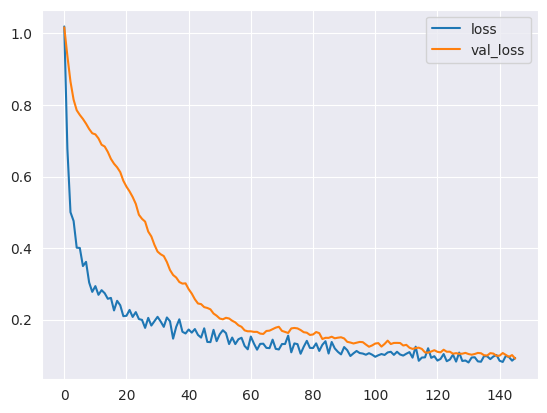

Epoch 1/1000
6/6 [==============================] - 5s 123ms/step - loss: 2.6805 - val_loss: 2.6983
Epoch 2/1000
6/6 [==============================] - 0s 18ms/step - loss: 1.3843 - val_loss: 2.3167
Epoch 3/1000
6/6 [==============================] - 0s 17ms/step - loss: 0.9744 - val_loss: 2.0094
Epoch 4/1000
6/6 [==============================] - 0s 18ms/step - loss: 0.7401 - val_loss: 1.8164
Epoch 5/1000
6/6 [==============================] - 0s 18ms/step - loss: 0.5623 - val_loss: 1.6905
Epoch 6/1000
6/6 [==============================] - 0s 17ms/step - loss: 0.3977 - val_loss: 1.5821
Epoch 7/1000
6/6 [==============================] - 0s 16ms/step - loss: 0.3602 - val_loss: 1.4767
Epoch 8/1000
6/6 [==============================] - 0s 16ms/step - loss: 0.2960 - val_loss: 1.3730
Epoch 9/1000
6/6 [==============================] - 0s 16ms/step - loss: 0.2666 - val_loss: 1.2701
Epoch 10/1000
6/6 [==============================] - 0s 17ms/step - loss: 0.2308 - val_loss: 1.1866
Epoch 11

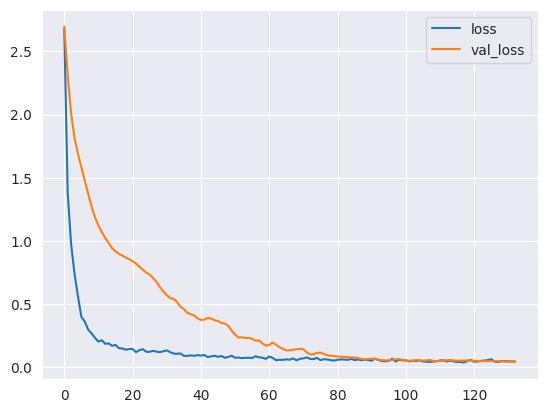

Date        Open        High         Low       Close  \
0   2021-11-03 00:00:00+05:30  136.856163  139.215759  136.164566  138.117325   
1   2021-11-04 00:00:00+05:30  139.297115  139.459843  138.117323  138.890289   
2   2021-11-08 00:00:00+05:30  139.134411  141.738093  137.100282  139.703964   
3   2021-11-09 00:00:00+05:30  139.988732  140.273502  137.995288  138.727570   
4   2021-11-10 00:00:00+05:30  138.239363  139.012342  135.432268  135.635681   
..                        ...         ...         ...         ...         ...   
492 2023-10-30 00:00:00+05:30  315.000000  315.799988  311.950012  314.549988   
493 2023-10-31 00:00:00+05:30  316.750000  316.799988  310.750000  314.250000   
494 2023-11-01 00:00:00+05:30  313.200012  315.799988  305.850006  306.649994   
495 2023-11-02 00:00:00+05:30  308.950012  312.799988  307.299988  308.850006   
496 2023-11-03 00:00:00+05:30  310.600006  314.700012  310.299988  312.000000   

      Volume  Dividends  Stock Splits  
0    8974463        0.0           0.0  
1     973260        0.0           0.0  
2    8761953        0.0           0.0  
3    5723308        0.0           0.0  
4    9212143        0.0           0.0  
..       ...        ...           ...  
492  6229982        0.0           0.0  
493  7446586        0.0           0.0  
494  9593653        0.0           0.0  
495  7071960        0.0           0.0  
496  4658440        0.0           0.0  

[497 rows x 8 columns]

In [1]:
fig = px.line(df_reliance, x='Date', y="Open")
fig.show()

NameError: name 'px' is not defined